In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# 1. Define the Circuit Dynamics
def circuit_dynamics(y, t, input_func):
    # y[0] = Fast Branch Protein (A), y[1] = Slow Branch Protein (B)
    A, B = y
    
    # Get the current input signal (Protein X concentration)
    X = input_func(t)
    
    # Parameters for the High-Pass (Fast) Branch
    beta_a = 5.0    # Rapid production
    gamma_a = 2.0   # Fast degradation (SsrA tagged)
    
    # Parameters for the Low-Pass (Slow) Branch
    beta_b = 1.0    # Slower production
    gamma_b = 0.2   # Slow degradation (Untagged)
    
    # ODEs
    dAdt = beta_a * X - gamma_a * A
    dBdt = beta_b * X - gamma_b * B
    
    return [dAdt, dBdt]

# 2. Define the Input Signal (Pulsing Protein Concentration)
def get_input(t, freq):
    # Square wave representing pulses of input protein
    return 1.0 if (np.sin(2 * np.pi * freq * t) > 0) else 0.0

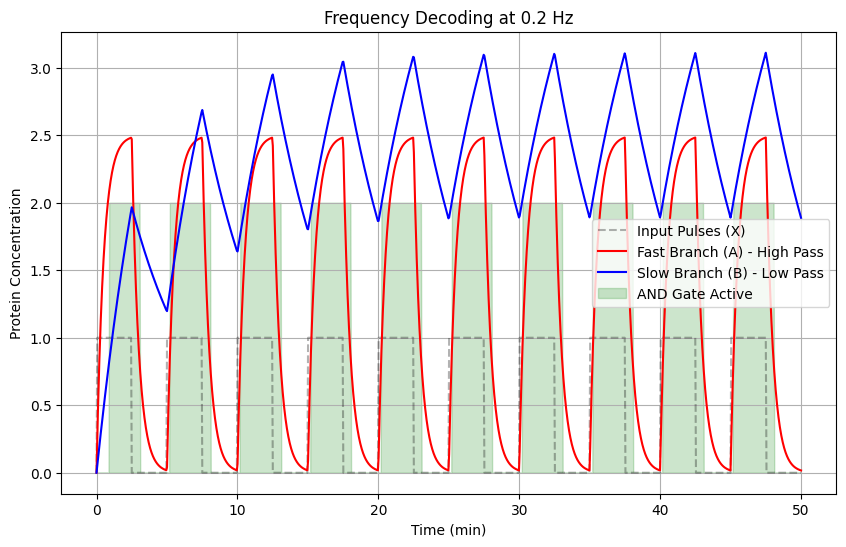

In [7]:
# 3. Simulation Parameters
t = np.linspace(0, 50, 1000)
y0 = [0, 0]  # Initial concentrations
test_freq = 0.2  # Adjust this to see how the filter responds!

# Run simulation
sol = odeint(circuit_dynamics, y0, t, args=(lambda t: get_input(t, test_freq),))

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.plot(t, [get_input(ti, test_freq) for ti in t], 'k--', alpha=0.3, label='Input Pulses (X)')
plt.plot(t, sol[:, 0], 'r', label='Fast Branch (A) - High Pass')
plt.plot(t, sol[:, 1], 'b', label='Slow Branch (B) - Low Pass')

# Model the AND gate (Output exists only if both A and B are above a threshold)
threshold = 0.8
and_gate = (sol[:, 0] > threshold) & (sol[:, 1] > threshold)
plt.fill_between(t, 0, and_gate.astype(int) * 2, color='green', alpha=0.2, label='AND Gate Active')

plt.title(f"Frequency Decoding at {test_freq} Hz")
plt.xlabel("Time (min)")
plt.ylabel("Protein Concentration")
plt.legend()
plt.grid(True)
plt.show()

# IFFL

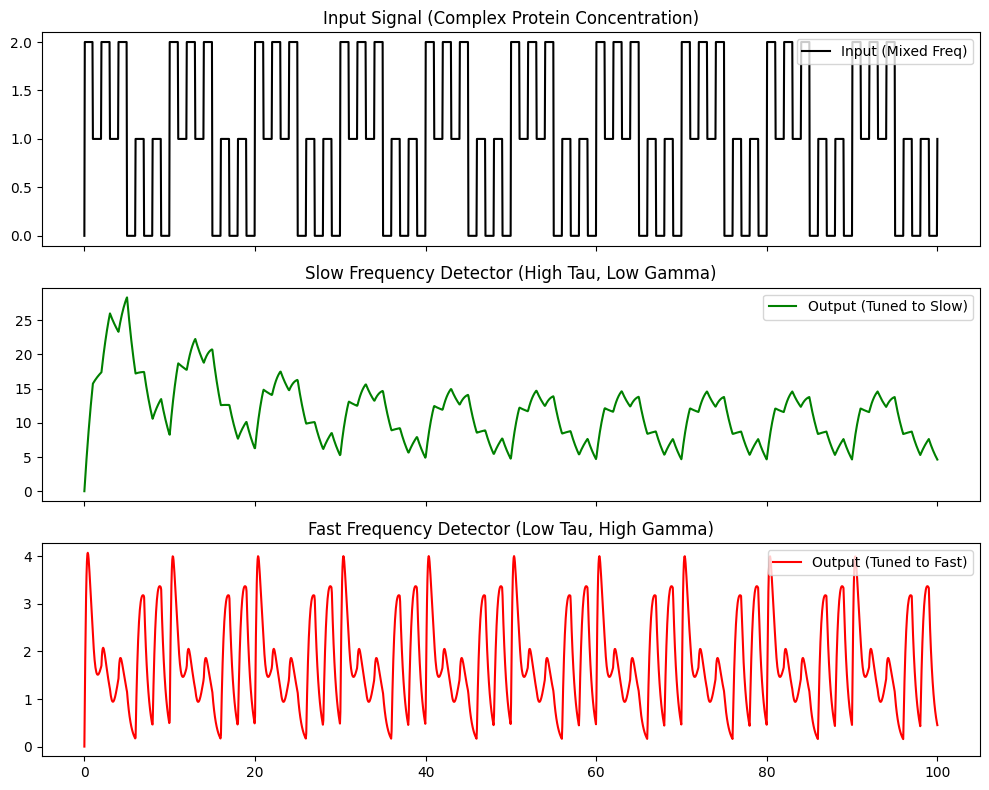

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def tunable_iffl(y, t, input_func, beta, gamma, tau):
    # A = Activator, R = Repressor
    A, R = y
    X = input_func(t)
    
    # R follows X with a delay defined by tau
    # A is produced by X but inhibited by R
    dRdt = (X - R) / tau
    dAdt = beta * (X / (1 + R**n)) - gamma * A
    
    return [dAdt, dRdt]

# Global Hill coefficient for sharp repression
n = 4

# Define an input signal with TWO frequencies: 0.1 Hz and 0.5 Hz
def complex_input(t):
    sig = (np.sin(2 * np.pi * 0.1 * t) > 0).astype(float) # Slow
    sig += (np.sin(2 * np.pi * 0.5 * t) > 0).astype(float) # Fast
    return sig

t = np.linspace(0, 100, 2000)

# --- CASE 1: Tuned for SLOW Frequencies ---
# Large tau (long memory) and low gamma
sol_slow = odeint(tunable_iffl, [0, 0], t, args=(complex_input, 10, 0.5, 10.0))

# --- CASE 2: Tuned for FAST Frequencies ---
# Small tau (short memory) and high gamma
sol_fast = odeint(tunable_iffl, [0, 0], t, args=(complex_input, 10, 2.0, 0.5))

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax1.plot(t, [complex_input(ti) for ti in t], 'k', label="Input (Mixed Freq)")
ax1.set_title("Input Signal (Complex Protein Concentration)")
ax1.legend()

ax2.plot(t, sol_slow[:, 0], 'g', label="Output (Tuned to Slow)")
ax2.set_title("Slow Frequency Detector (High Tau, Low Gamma)")
ax2.legend()

ax3.plot(t, sol_fast[:, 0], 'r', label="Output (Tuned to Fast)")
ax3.set_title("Fast Frequency Detector (Low Tau, High Gamma)")
ax3.legend()

plt.tight_layout()
plt.show()


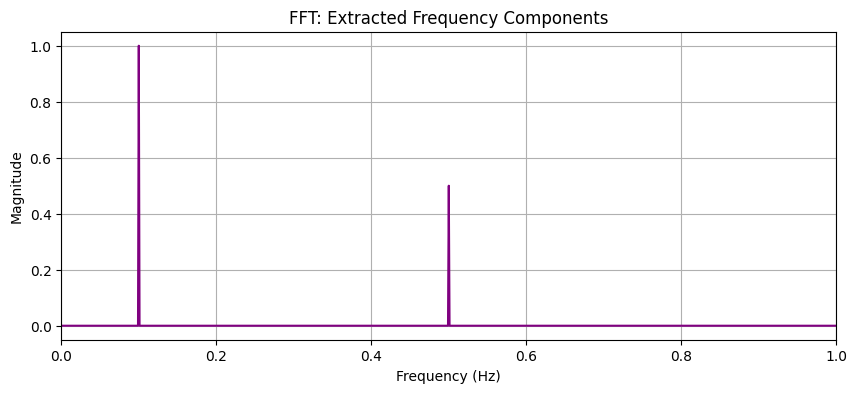

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Signal
Fs = 10.0            # Sampling Frequency (samples per second)
T = 1.0 / Fs         # Sampling interval
L = 1000             # Length of signal (seconds)
t = np.arange(0, L, T)

# Generate a complex protein signal: 0.1 Hz (Slow) + 0.5 Hz (Fast)
signal = np.sin(2 * np.pi * 0.1 * t) + 0.5 * np.sin(2 * np.pi * 0.5 * t)

# 2. Perform FFT
# Use np.fft.fft to compute the transform
yf = np.fft.fft(signal)
# Use np.fft.fftfreq to get the frequency axis
xf = np.fft.fftfreq(len(t), T)

# 3. Process for Plotting (Take absolute value for magnitude)
# We only care about positive frequencies
idx = np.where(xf >= 0)
xf_pos = xf[idx]
yf_mag = np.abs(yf[idx]) * (2.0 / len(t)) # Normalize magnitude

# 4. Visualization
plt.figure(figsize=(10, 4))
plt.plot(xf_pos, yf_mag, color='purple')
plt.title("FFT: Extracted Frequency Components")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 1.0) # Zoom into the relevant range
plt.grid()
plt.show()
